## **Predicting Disease Spread: Prediction comparison**

### **Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os

import joblib

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

sys.path.append(os.path.abspath(".."))
from src.data_setup import load_data, split_cities
from src.pipeline import create_pipeline
from src.inference import create_diff_target, predict_on_test, predict_on_test_normal
from src.visualization import visualize_predictions

In [2]:
prophet_mean = pd.read_csv('../data/predictions/prophet_mean.csv')
arima = pd.read_csv('../data/predictions/arima.csv')
as_mean = pd.read_csv('../data/predictions/estimated_as_mean.csv')
prev_iter_rf = pd.read_csv('../data/predictions/prev_as_iterative_rf_sep_cities.csv')
ensemble_prophet_arima = pd.read_csv('../data/predictions/ensemble/prophet_arima.csv')
maximum_df = pd.read_csv('../data/predictions/ensemble/maximum.csv')
max_for_sj_mean_for_iq = pd.read_csv('../data/predictions/ensemble/mean_for_iq_max_for_sj.csv')
proph_arima_mean_roll_3 = pd.read_csv('../data/predictions/ensemble/proph_arima_mean_roll_3.csv')
as_mean_roll_3 = pd.read_csv('../data/predictions/ensemble/as_mean_roll_3.csv')
predicted_as_last_value_for_week_df = pd.read_csv('../data/predictions/ensemble/predicted_as_last_value_for_week.csv')
lastweek_proph_arima_mean_roll_3_mean = pd.read_csv('../data/predictions/ensemble/lastweek_proph_arima_mean_roll_3_mean.csv')
predicted_as_last_value_for_week_roll_3_df = pd.read_csv('../data/predictions/ensemble/predicted_as_last_value_for_week_roll_3.csv')
improved = pd.read_csv('../data/predictions/ensemble/improved.csv')
improved_quantile = pd.read_csv('../data/predictions/ensemble/improved_quantile_iq.csv')
weather_lags = pd.read_csv('../data/predictions/weather_lags_gs.csv')


In [3]:
def plot_predictions(*predictions):
    """
    Plots predictions for San Juan and Iquitos on separate plots with all predictions.

    Parameters:
    predictions: List of tuples where each tuple contains:
        - prediction (pd.DataFrame): The prediction DataFrame.
        - mae (float): The Mean Absolute Error.
        - title (str): The title for the prediction.
    """
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 16), sharex=True)

    for prediction, mae, title in predictions:
        prediction['date'] = pd.to_datetime(prediction['year'].astype(str) + '-W' + prediction['weekofyear'].astype(str) + '-1', format='%Y-W%U-%w')
        sj_prediction = prediction[prediction['city'] == 'sj']
        iq_prediction = prediction[prediction['city'] == 'iq']

        sns.lineplot(data=sj_prediction, x="date", y='total_cases', ax=axes[0], label=f"{title} MAE: {mae}")
        sns.lineplot(data=iq_prediction, x="date", y='total_cases', ax=axes[1], label=f"{title} MAE: {mae}")

    axes[0].set_title('Predictions for San Juan')
    axes[0].legend()
    axes[1].set_title('Predictions for Iquitos')
    axes[1].legend()

    plt.tight_layout()


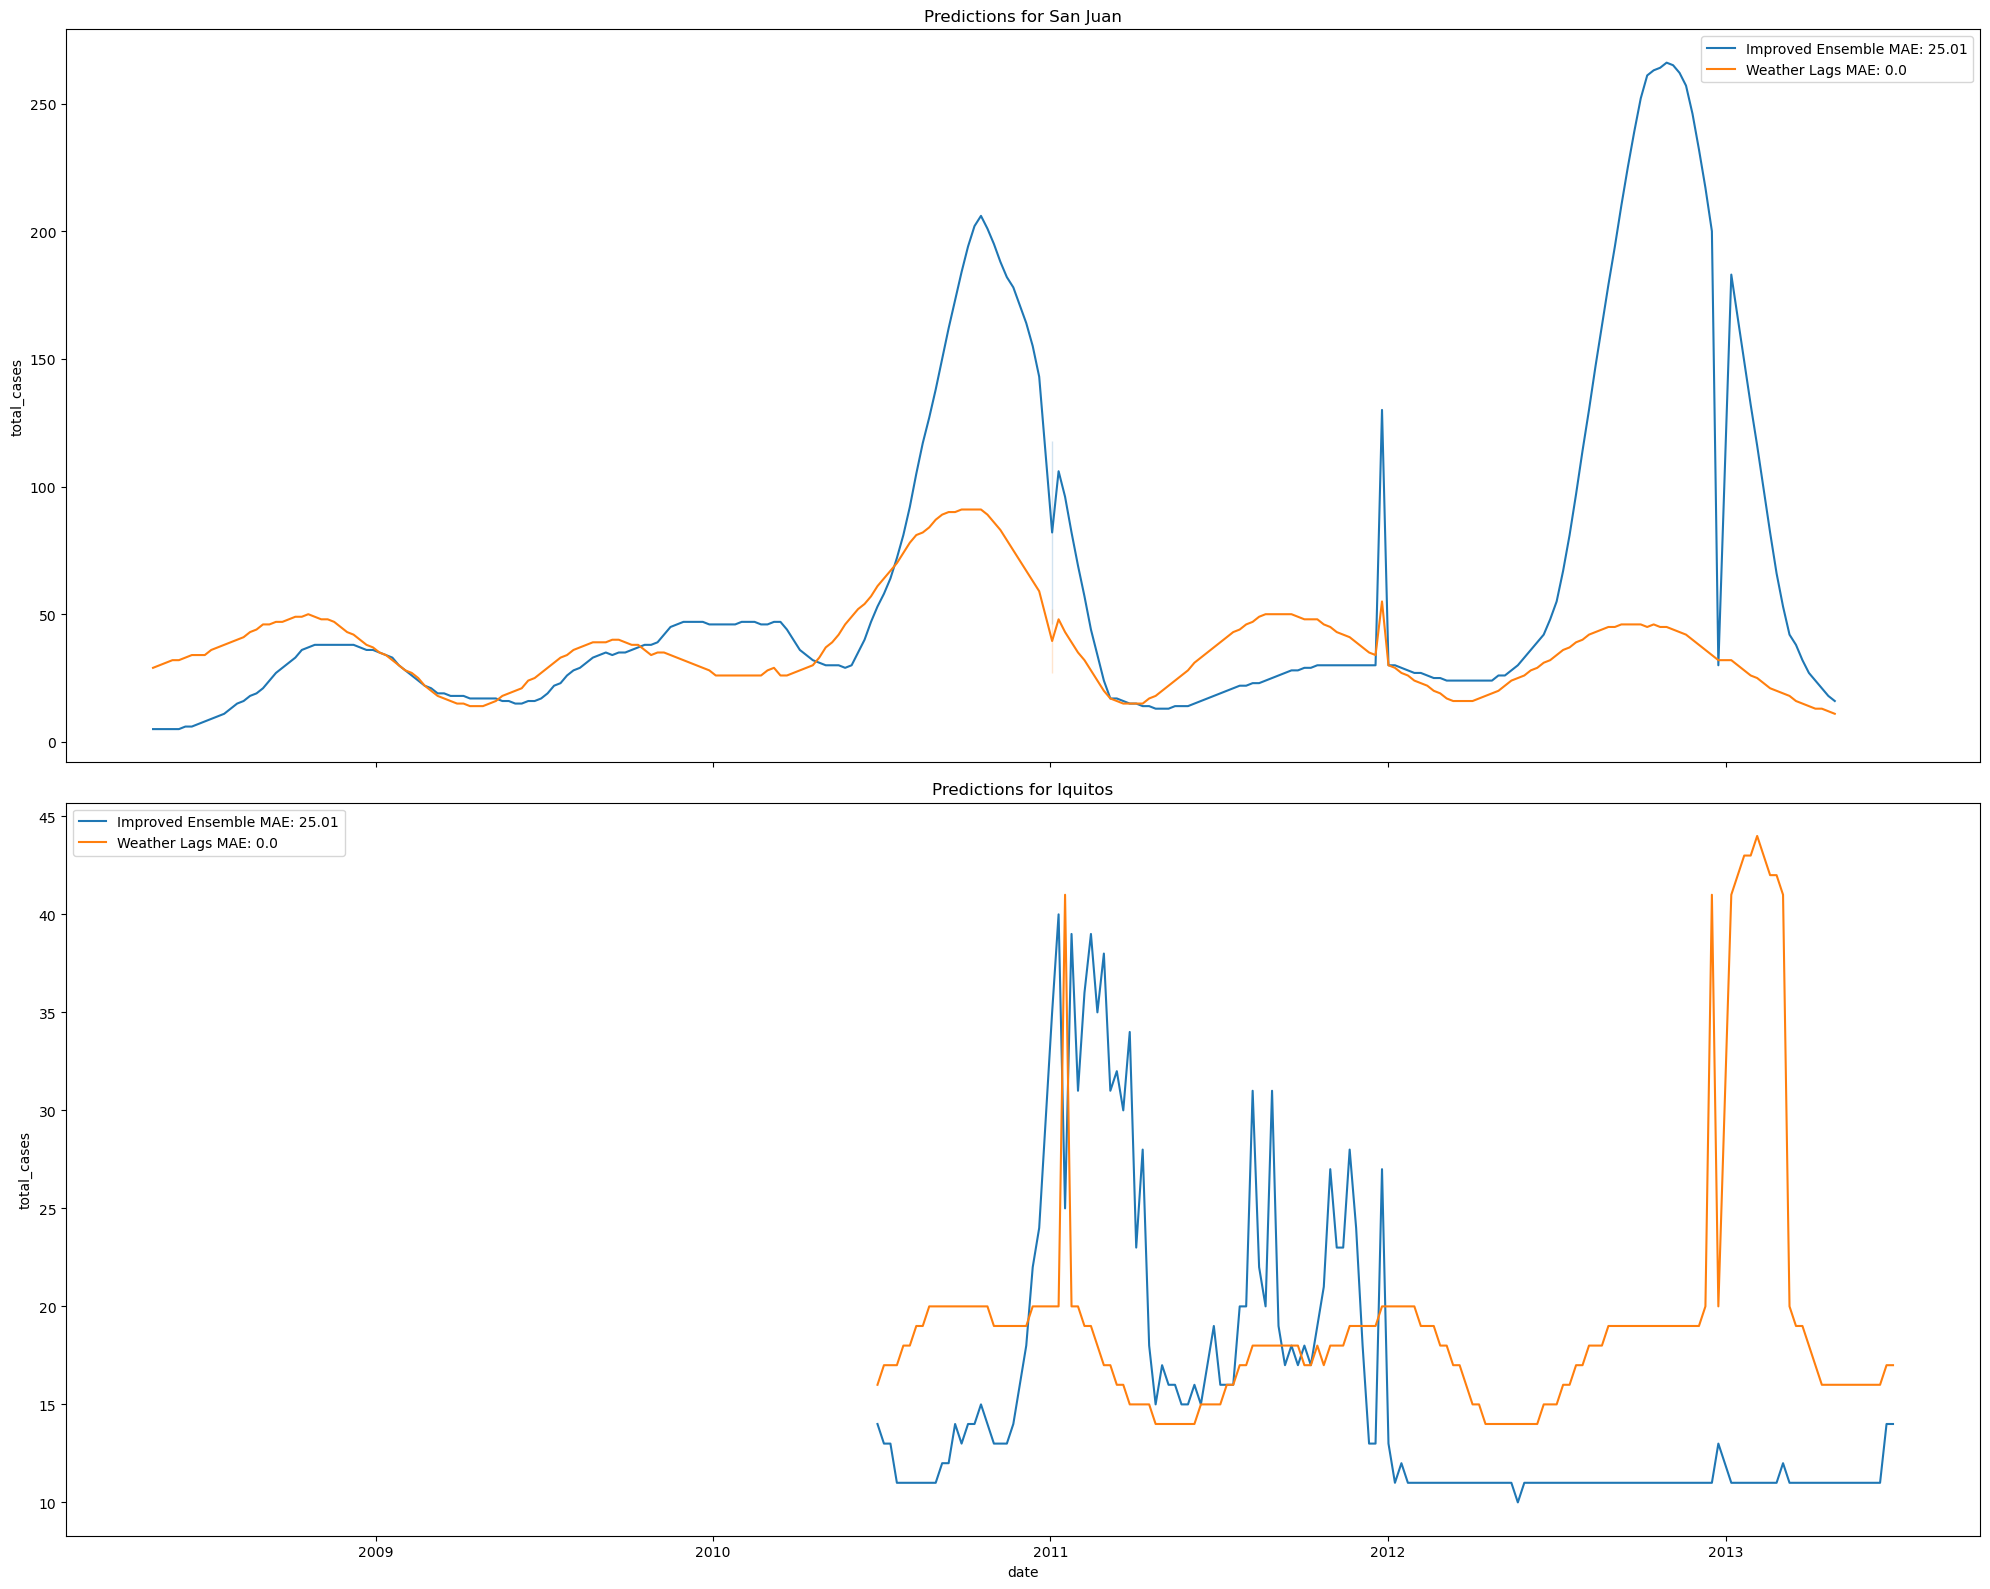

In [4]:
plot_predictions(
    # (prophet_mean, 27.10, 'Prophet Mean'),
    # (arima, 26.37, 'ARIMA'),
    # (prev_iter_rf, 26.75, 'Prev Iter RF'),
    # (as_mean, 26.24, 'AS Mean'),
    # (ensemble_prophet_arima, 25.88, 'Ensemble Prophet ARIMA'),
    # (maximum_df, 27.51, 'Maximum'),
    # (max_for_sj_mean_for_iq, 0.0, 'Max for SJ Mean for IQ'),
    # (proph_arima_mean_roll_3, 25.62, 'P, AMean Roll 3'),
    # (as_mean_roll_3, 0.0, 'AS Mean Roll 3'),
    # (predicted_as_last_value_for_week_df, 0.0, 'Predicted AS Last Value for Week'),
    # (lastweek_proph_arima_mean_roll_3_mean, 0.0, 'Lastweek P, AMean Roll 3 Mean'),
    # (predicted_as_last_value_for_week_roll_3_df, 28.29, 'Predicted AS Last Value for Week Roll 3'),
    (improved, 25.01, 'Improved Ensemble'),
    # (improved_quantile, 0.0, 'Improved Quantile Ensemble'),
    (weather_lags, 0.0, 'Weather Lags'),
    
)

Below, there is code to existing ensebles

In [36]:
def weighted_average(predictions, weights):
    """
    Computes the weighted average of predictions.

    Parameters:
    predictions (list): List of prediction DataFrames.
    weights (list): List of weights for each prediction.

    Returns:
    pd.DataFrame: DataFrame containing the weighted average predictions.
    """
    
    weighted_sum = sum(weight * pred['total_cases'] for weight, pred in zip(weights, predictions))
    total_weight = sum(weights)
    
    res = weighted_sum / total_weight
    res = res.astype(int)
    submission_format = pd.read_csv('../data/submission_format.csv')
    
    submission_format['total_cases'] = res
    return submission_format

In [28]:
def maximum(predictions):
    """
    Computes the maximum of predictions.

    Parameters:
    predictions (list): List of prediction DataFrames.

    Returns:
    pd.DataFrame: DataFrame containing the maximum predictions.
    """
    
    max_pred = pd.concat(predictions, axis=0).groupby(['city', 'year', 'weekofyear'], as_index = False).max()
    submission_format = pd.read_csv('../data/submission_format.csv')
    submission_format = submission_format.merge(max_pred, on=['city', 'year', 'weekofyear'], how='left')
    submission_format['total_cases'] = submission_format['total_cases_y']
    submission_format = submission_format.drop(columns=['total_cases_x', 'total_cases_y', 'date'])
    return submission_format

In [21]:
arima

,city,year,weekofyear,total_cases
0,sj,2008,18,9
1,sj,2008,19,9
2,sj,2008,20,11
3,sj,2008,21,10
4,sj,2008,22,16
...,...,...,...,...
411,iq,2013,22,6
412,iq,2013,23,8
413,iq,2013,24,4
414,iq,2013,25,4


In [22]:
df_mean = weighted_average([prophet_mean, arima], [0.5, 0.5])
# df.to_csv('../data/predictions/ensemble/prophet_arima.csv', index=False)

In [29]:
df_maximum = maximum([prophet_mean, arima, as_mean])
df_maximum.to_csv('../data/predictions/ensemble/maximum.csv', index=False)

In [30]:
# maximum for SJ and mean for IQ
df_mean_max = pd.concat([df_maximum[df_maximum['city'] == 'sj'], df_mean[df_mean['city'] == 'iq']])
df_mean_max.to_csv('../data/predictions/ensemble/mean_for_iq_max_for_sj.csv', index=False)

In [37]:
df_mean

,city,year,weekofyear,total_cases
0,sj,2008,18,15
1,sj,2008,19,11
2,sj,2008,20,17
3,sj,2008,21,22
4,sj,2008,22,22
...,...,...,...,...
411,iq,2013,22,3
412,iq,2013,23,4
413,iq,2013,24,2
414,iq,2013,25,2


In [73]:
df_mean_roll = df_mean.copy()
df_mean_roll['total_cases'] = df_mean['total_cases'].rolling(3).mean()
df_mean_roll = df_mean_roll.interpolate(method="bfill")
df_mean_roll['total_cases'] = df_mean_roll['total_cases'].astype(int)
df_mean_roll
df_mean_roll.to_csv('../data/predictions/ensemble/proph_arima_mean_roll_3.csv', index=False)


/var/folders/3h/472d34x91dd8vpqfg3cg45qh0000gn/T/ipykernel_72726/1440173421.py:3: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_mean_roll = df_mean_roll.interpolate(method="bfill")


In [80]:
as_mean

,city,year,weekofyear,total_cases
0,sj,2008,18,11
1,sj,2008,19,10
2,sj,2008,20,12
3,sj,2008,21,11
4,sj,2008,22,14
...,...,...,...,...
411,iq,2013,22,5
412,iq,2013,23,3
413,iq,2013,24,3
414,iq,2013,25,4


In [82]:
proph_arima_mean_roll_3.head(10)

,city,year,weekofyear,total_cases
0,sj,2008,18,14
1,sj,2008,19,14
2,sj,2008,20,14
3,sj,2008,21,16
4,sj,2008,22,20
5,sj,2008,23,21
6,sj,2008,24,20
7,sj,2008,25,22
8,sj,2008,26,23
9,sj,2008,27,23


In [89]:
df_roll = as_mean.copy()
df_roll['total_cases'] = as_mean['total_cases'].rolling(3).mean()
df_roll = df_roll.interpolate(method="bfill")
df_roll['total_cases'] = df_roll['total_cases'].astype(int)
df_roll.head(10)
df_roll.to_csv('../data/predictions/ensemble/as_mean_roll_3.csv', index=False)

/var/folders/3h/472d34x91dd8vpqfg3cg45qh0000gn/T/ipykernel_72726/652553114.py:3: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_roll = df_roll.interpolate(method="bfill")


In [3]:
features_train, target_train = load_data(train=True)
sj_features_train, iq_features_train = split_cities(features_train)
sj_target_train, iq_target_train = split_cities(target_train)

features_test, _ = load_data(train=False)
sj_features_test, iq_features_test = split_cities(features_test)

In [ ]:
def predict_as_last_value_for_week(sj_target_train: pd.DataFrame, iq_target_train: pd.DataFrame, submission_format: pd.DataFrame) -> pd.DataFrame:
    
    sj_tail_df = sj_target_train.tail(53).reset_index(drop=False)
    iq_tail_df = iq_target_train.tail(53).reset_index(drop=False)
    sj_tail_df['city'] = 'sj'
    iq_tail_df['city'] = 'iq'
    
    tail_df = pd.concat([sj_tail_df, iq_tail_df], axis=0)
    tail_df = tail_df[['city', 'weekofyear', 'total_cases']]
    
    res = submission_format.merge(tail_df, on=['city', 'weekofyear'], how='left')
    res['total_cases'] = res['total_cases_y']
    res = res.drop(columns=['total_cases_x', 'total_cases_y'])
    res = res.interpolate(method="bfill")
    res = res.groupby(['city', 'year', 'weekofyear'], as_index=False)['total_cases'].mean()
    res = pd.concat([res[res['city'] == 'sj'], res[res['city'] == 'iq']], axis=0)
    res['total_cases'] = res['total_cases'].astype(int)
    return res
    
# submission_format = pd.read_csv('../data/submission_format.csv')
# predicted_as_last_value_for_week_df = predict_as_last_value_for_week(sj_target_train, iq_target_train, submission_format)
# predicted_as_last_value_for_week_df.to_csv('../data/predictions/ensemble/predicted_as_last_value_for_week.csv', index=False)

/var/folders/3h/472d34x91dd8vpqfg3cg45qh0000gn/T/ipykernel_78336/4120218380.py:14: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  res = res.interpolate(method="bfill")


In [37]:
lastweek_proph_arima_mean_roll_3_mean = weighted_average([proph_arima_mean_roll_3, predicted_as_last_value_for_week_df], [0.5, 0.5])
lastweek_proph_arima_mean_roll_3_mean.to_csv('../data/predictions/ensemble/lastweek_proph_arima_mean_roll_3_mean.csv', index=False)

In [61]:
predicted_as_last_value_for_week_df

,city,year,weekofyear,total_cases,date
0,sj,2008,18,10,2008-05-05
1,sj,2008,19,8,2008-05-12
2,sj,2008,20,13,2008-05-19
3,sj,2008,21,10,2008-05-26
4,sj,2008,22,21,2008-06-02
...,...,...,...,...,...
411,iq,2013,22,8,2013-06-03
412,iq,2013,23,1,2013-06-10
413,iq,2013,24,1,2013-06-17
414,iq,2013,25,4,2013-06-24


In [65]:
predicted_as_last_value_for_week_df

,city,year,weekofyear,total_cases,date
0,sj,2008,18,10,2008-05-05
1,sj,2008,19,8,2008-05-12
2,sj,2008,20,13,2008-05-19
3,sj,2008,21,10,2008-05-26
4,sj,2008,22,21,2008-06-02
...,...,...,...,...,...
411,iq,2013,22,8,2013-06-03
412,iq,2013,23,1,2013-06-10
413,iq,2013,24,1,2013-06-17
414,iq,2013,25,4,2013-06-24


/var/folders/3h/472d34x91dd8vpqfg3cg45qh0000gn/T/ipykernel_11928/47887455.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  iq_rolled['total_cases'] = iq_rolled['total_cases'].rolling(15).mean().fillna(method='bfill').astype(int)
/var/folders/3h/472d34x91dd8vpqfg3cg45qh0000gn/T/ipykernel_11928/47887455.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sj_rolled = sj_weighted.rolling(10).mean().fillna(method='bfill').astype(int)


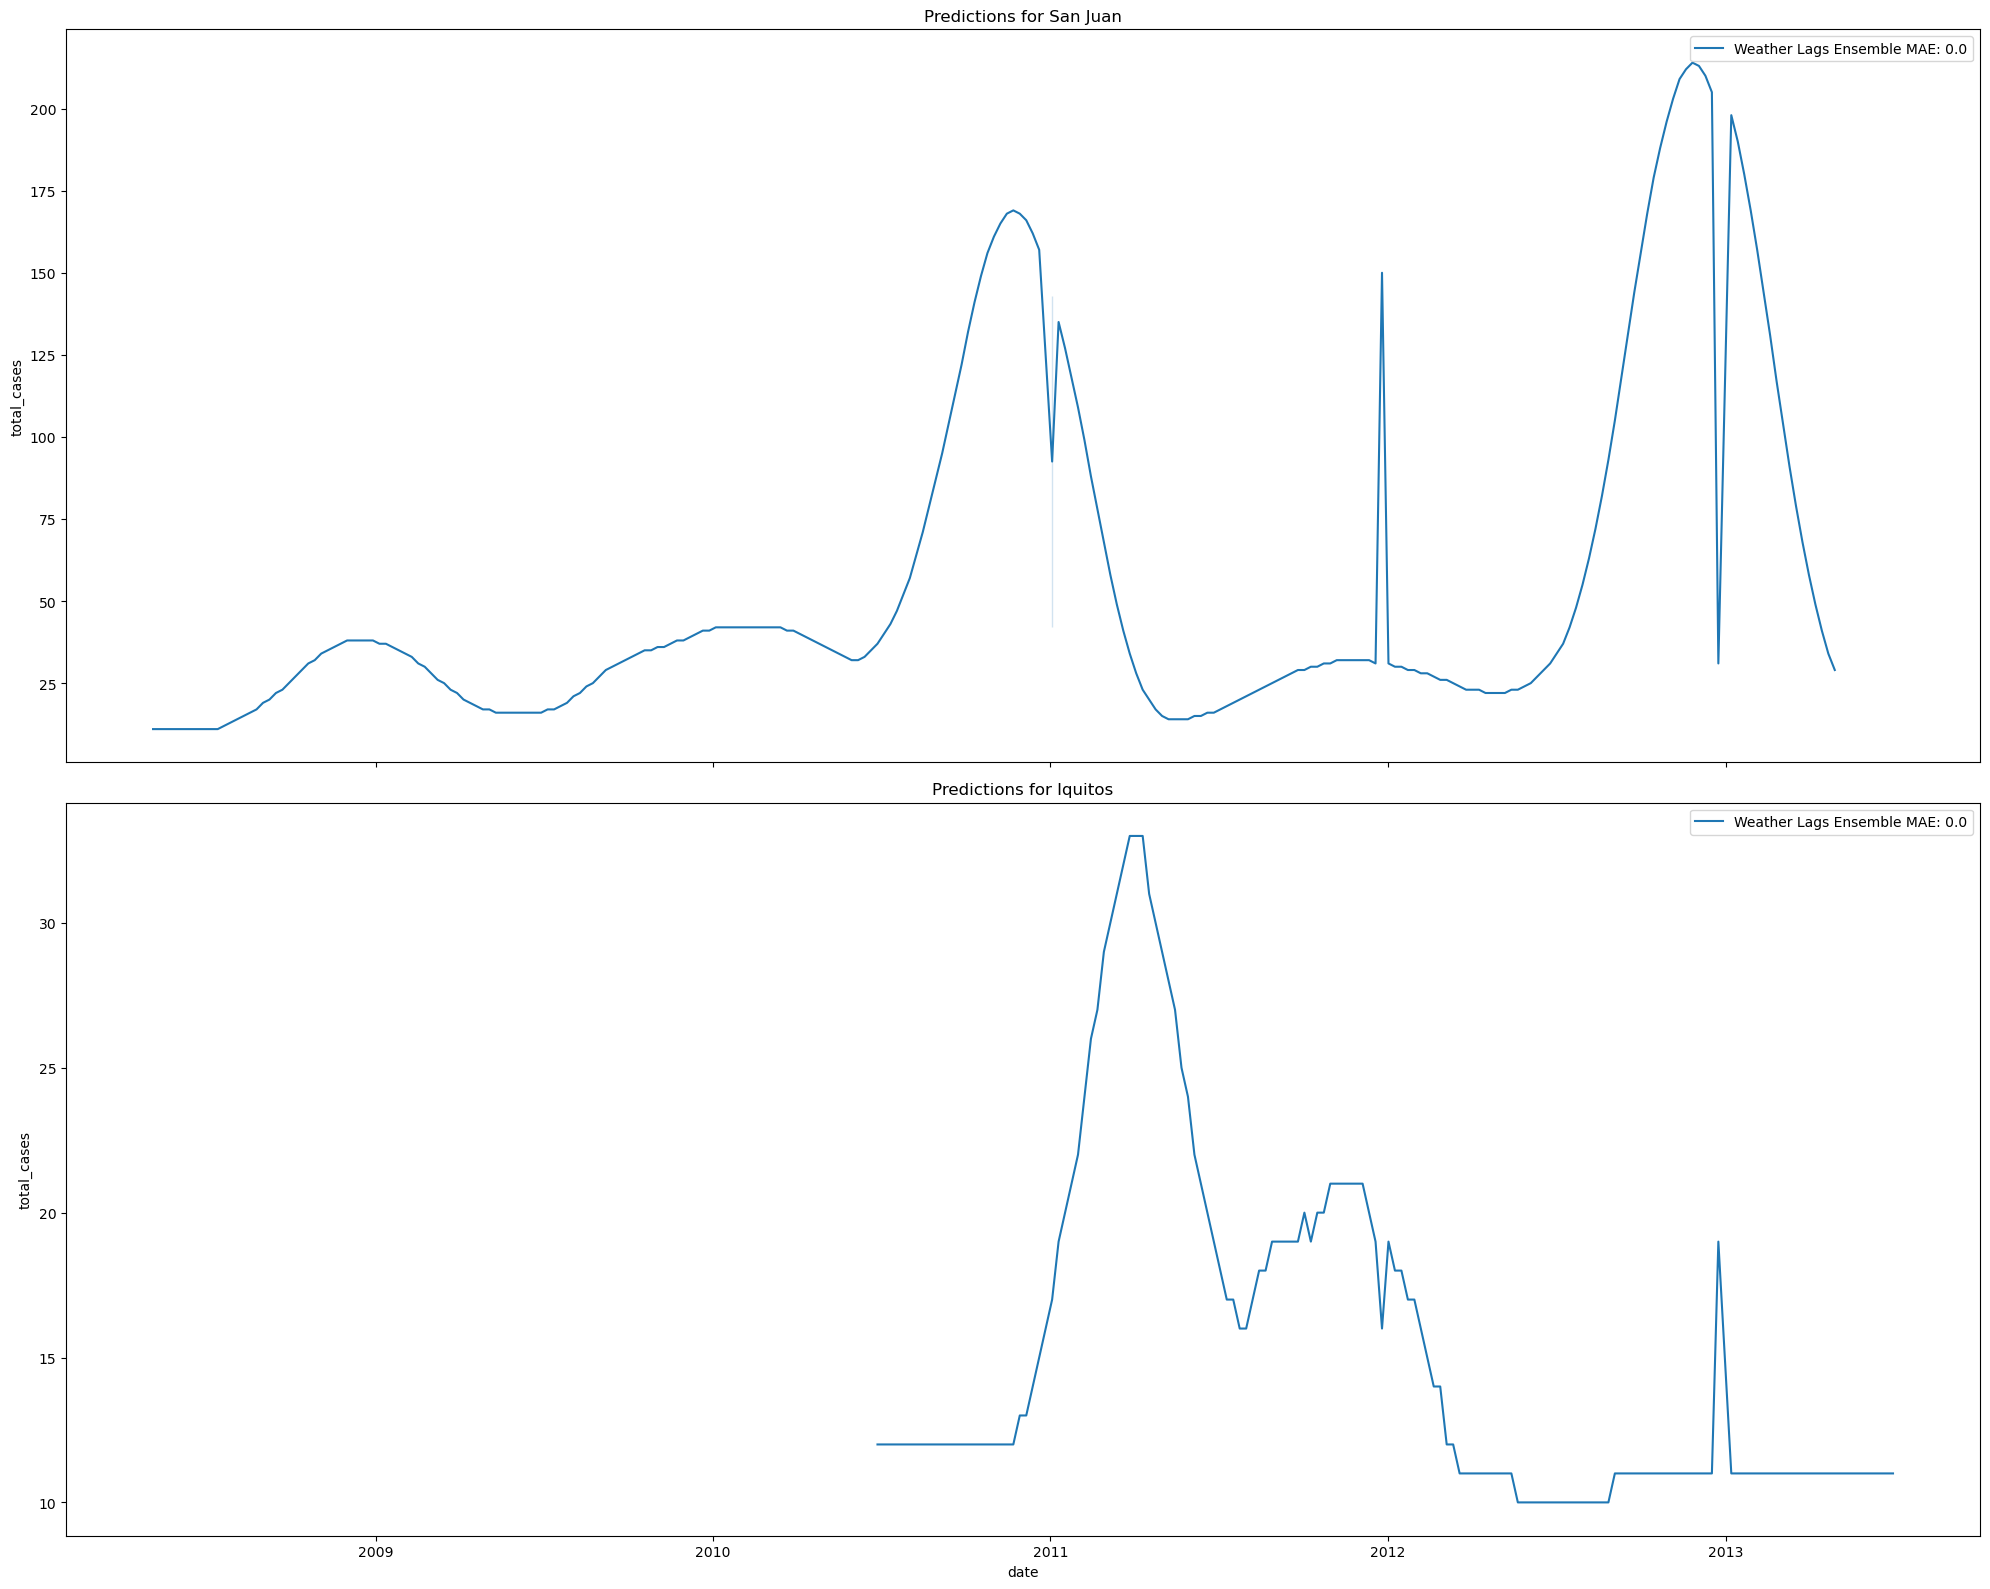

In [34]:
df = weather_lags.copy()
sj_weighted = (0.8 * improved[improved['city'] == 'sj']['total_cases'] + 
               0.2 * weather_lags[weather_lags['city'] == 'sj']['total_cases']).astype(int)

iq_rolled = improved[improved['city'] == 'iq'].copy()
iq_rolled['total_cases'] = iq_rolled['total_cases'].rolling(15).mean().fillna(method='bfill').astype(int)

sj_rolled = sj_weighted.rolling(10).mean().fillna(method='bfill').astype(int)

df.loc[df['city'] == 'sj', 'total_cases'] = sj_rolled.values
df.loc[df['city'] == 'iq', 'total_cases'] = iq_rolled['total_cases'].values
plot_predictions((df, 0.0, 'Weather Lags Ensemble'))

In [35]:
df = df.drop(columns='date')
df.to_csv('../data/predictions/ensemble/weather_lags_and_improved_3.csv', index=False)